# Package loading and basic configurations

In [2]:
%load_ext autoreload
%autoreload 2

# load dependencies'
import matplotlib.pyplot as plt
import scipy
from scipy.misc import derivative
import datetime
import numpy as np
import pandas as pd
import geopandas as gpd
from envirocar import TrackAPI, DownloadClient, BboxSelector, TimeSelector, ECConfig

# create an initial but optional config and an api client
config = ECConfig()
track_api = TrackAPI(api_client=DownloadClient(config=config))

# Querying enviroCar Tracks

The following cell queries tracks from the enviroCar API. It defines a bbox for the area of Münster (Germany) and requests 50 tracks in the time interval. 

In [109]:
bbox = BboxSelector([
    7.603312, # min_x
    51.952343, # min_y
    7.65083, # max_x 
    51.974045,  # max_y 
])


# issue a query
track_df = track_api.get_tracks(bbox=bbox,  num_results=50) # requesting 50 tracks inside the bbox
track_df


,id,time,geometry,Calculated MAF.value,Calculated MAF.unit,Intake Pressure.value,Intake Pressure.unit,CO2.value,CO2.unit,Intake Temperature.value,...,sensor.constructionYear,sensor.manufacturer,track.appVersion,track.touVersion,O2 Lambda Voltage ER.value,O2 Lambda Voltage ER.unit,MAF.value,MAF.unit,O2 Lambda Voltage.value,O2 Lambda Voltage.unit
0,5eb7582c65b80c5d6be6b013,2020-05-09T23:45:27,POINT (7.61924 51.97461),10.745416,g/s,53.000002,kPa,8.300800,kg/h,27.000000,...,2007,Dodge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5eb7582c65b80c5d6be6b015,2020-05-09T23:45:32,POINT (7.61820 51.97455),14.033751,g/s,70.000000,kPa,10.841030,kg/h,26.999999,...,2007,Dodge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5eb7582c65b80c5d6be6b016,2020-05-09T23:45:37,POINT (7.61713 51.97449),15.175984,g/s,71.000002,kPa,11.723401,kg/h,26.000000,...,2007,Dodge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5eb7582c65b80c5d6be6b017,2020-05-09T23:45:42,POINT (7.61598 51.97444),15.874530,g/s,70.613516,kPa,12.263026,kg/h,25.000000,...,2007,Dodge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5eb7582c65b80c5d6be6b018,2020-05-09T23:45:47,POINT (7.61482 51.97439),5.565244,g/s,25.223188,kPa,4.299134,kg/h,24.999999,...,2007,Dodge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,5dcbbb0244ea856b7037abb0,2019-09-23T15:08:44,POINT (7.60279 51.95492),5.773059,g/s,27.112427,kPa,4.459670,kg/h,22.000000,...,2004,Mercedes Benz,"Version 0.22.5 (34), 11/30/79 00:00",2013-10-01,NaN,NaN,NaN,NaN,NaN,NaN
170,5dcbbb0244ea856b7037abb1,2019-09-23T15:08:49,POINT (7.60282 51.95524),5.673428,g/s,42.442857,kPa,4.382706,kg/h,24.000000,...,2004,Mercedes Benz,"Version 0.22.5 (34), 11/30/79 00:00",2013-10-01,NaN,NaN,NaN,NaN,NaN,NaN
171,5dcbbb0244ea856b7037abb2,2019-09-23T15:08:54,POINT (7.60285 51.95556),13.116699,g/s,44.271586,kPa,10.132610,kg/h,21.616667,...,2004,Mercedes Benz,"Version 0.22.5 (34), 11/30/79 00:00",2013-10-01,NaN,NaN,NaN,NaN,NaN,NaN
172,5dcbbb0244ea856b7037abb3,2019-09-23T15:08:59,POINT (7.60291 51.95602),8.802338,g/s,33.821656,kPa,6.799779,kg/h,20.999999,...,2004,Mercedes Benz,"Version 0.22.5 (34), 11/30/79 00:00",2013-10-01,NaN,NaN,NaN,NaN,NaN,NaN


In [165]:
track_df.columns

Index(['id', 'time', 'geometry', 'Calculated MAF.value', 'Calculated MAF.unit',
       'Intake Pressure.value', 'Intake Pressure.unit', 'CO2.value',
       'CO2.unit', 'Intake Temperature.value', 'Intake Temperature.unit',
       'GPS VDOP.value', 'GPS VDOP.unit', 'GPS Accuracy.value',
       'GPS Accuracy.unit', 'Consumption.value', 'Consumption.unit',
       'GPS Bearing.value', 'GPS Bearing.unit', 'GPS Speed.value',
       'GPS Speed.unit', 'Engine Load.value', 'Engine Load.unit',
       'Speed.value', 'Speed.unit', 'GPS HDOP.value', 'GPS HDOP.unit',
       'Throttle Position.value', 'Throttle Position.unit', 'Rpm.value',
       'Rpm.unit', 'GPS PDOP.value', 'GPS PDOP.unit', 'GPS Altitude.value',
       'GPS Altitude.unit', 'track.id', 'track.length', 'track.begin',
       'track.end', 'sensor.type', 'sensor.engineDisplacement', 'sensor.model',
       'sensor.id', 'sensor.fuelType', 'sensor.constructionYear',
       'sensor.manufacturer', 'track.appVersion', 'track.touVersion',
    

## Filter the data

In [170]:
realistc_drive = track_df[['id','time','geometry', 'GPS Speed.value','track.id', 'track.length', 'track.begin', 'track.end', 'sensor.fuelType']]
x=realistc_drive['time']
x=[s.replace('T',' ') for s in (x)]
x= pd.Series(x)
x=pd.to_datetime(x)
realistc_drive['new'] = pd.Series(x)
realistc_drive
    

,id,time,geometry,GPS Speed.value,track.id,track.length,track.begin,track.end,sensor.fuelType,new
0,5eb7582c65b80c5d6be6b013,2020-05-09T23:45:27,POINT (7.61924 51.97461),52.062059,5eb7582c65b80c5d6be6b011,169.372465,2020-05-09T23:45:27Z,2020-05-10T01:22:21Z,gasoline,2020-05-09 23:45:27
1,5eb7582c65b80c5d6be6b015,2020-05-09T23:45:32,POINT (7.61820 51.97455),51.078148,5eb7582c65b80c5d6be6b011,169.372465,2020-05-09T23:45:27Z,2020-05-10T01:22:21Z,gasoline,2020-05-09 23:45:32
2,5eb7582c65b80c5d6be6b016,2020-05-09T23:45:37,POINT (7.61713 51.97449),54.317971,5eb7582c65b80c5d6be6b011,169.372465,2020-05-09T23:45:27Z,2020-05-10T01:22:21Z,gasoline,2020-05-09 23:45:37
3,5eb7582c65b80c5d6be6b017,2020-05-09T23:45:42,POINT (7.61598 51.97444),56.636457,5eb7582c65b80c5d6be6b011,169.372465,2020-05-09T23:45:27Z,2020-05-10T01:22:21Z,gasoline,2020-05-09 23:45:42
4,5eb7582c65b80c5d6be6b018,2020-05-09T23:45:47,POINT (7.61482 51.97439),56.469099,5eb7582c65b80c5d6be6b011,169.372465,2020-05-09T23:45:27Z,2020-05-10T01:22:21Z,gasoline,2020-05-09 23:45:47
...,...,...,...,...,...,...,...,...,...,...
169,5dcbbb0244ea856b7037abb0,2019-09-23T15:08:44,POINT (7.60279 51.95492),33.027446,5dcbbb0244ea856b7037ab04,7.657626,2019-09-23T14:54:25Z,2019-09-23T15:09:04Z,gasoline,2020-05-09 23:59:39
170,5dcbbb0244ea856b7037abb1,2019-09-23T15:08:49,POINT (7.60282 51.95524),16.656610,5dcbbb0244ea856b7037ab04,7.657626,2019-09-23T14:54:25Z,2019-09-23T15:09:04Z,gasoline,2020-05-09 23:59:44
171,5dcbbb0244ea856b7037abb2,2019-09-23T15:08:54,POINT (7.60285 51.95556),29.466324,5dcbbb0244ea856b7037ab04,7.657626,2019-09-23T14:54:25Z,2019-09-23T15:09:04Z,gasoline,2020-05-09 23:59:49
172,5dcbbb0244ea856b7037abb3,2019-09-23T15:08:59,POINT (7.60291 51.95602),39.672277,5dcbbb0244ea856b7037ab04,7.657626,2019-09-23T14:54:25Z,2019-09-23T15:09:04Z,gasoline,2020-05-09 23:59:54


## Add the time interval for each record

In [182]:
some_track_id = realistc_drive['track.id'].unique()[5]
some_track = realistc_drive[realistc_drive['track.id'] == some_track_id]
some_track
j = 0
for i in some_track.index:
    some_track.loc[i, 'time_interval'] = j
    j = j+5
some_track

,id,time,geometry,GPS Speed.value,track.id,track.length,track.begin,track.end,sensor.fuelType,new,time_interval
0,5e8b930965b80c5d6b4d7cd1,2020-03-07T12:33:15,POINT (7.64069 51.95733),28.867655,5e8b930965b80c5d6b4d7ccf,11.969578,2020-03-07T12:33:15Z,2020-03-07T12:50:00Z,gasoline,2020-05-09 23:45:27,0.0
1,5e8b930965b80c5d6b4d7cd3,2020-03-07T12:33:20,POINT (7.64118 51.95712),28.295928,5e8b930965b80c5d6b4d7ccf,11.969578,2020-03-07T12:33:15Z,2020-03-07T12:50:00Z,gasoline,2020-05-09 23:45:32,5.0
2,5e8b930965b80c5d6b4d7cd4,2020-03-07T12:33:26,POINT (7.64162 51.95690),27.615373,5e8b930965b80c5d6b4d7ccf,11.969578,2020-03-07T12:33:15Z,2020-03-07T12:50:00Z,gasoline,2020-05-09 23:45:37,10.0
3,5e8b930965b80c5d6b4d7cd5,2020-03-07T12:33:31,POINT (7.64210 51.95672),30.928370,5e8b930965b80c5d6b4d7ccf,11.969578,2020-03-07T12:33:15Z,2020-03-07T12:50:00Z,gasoline,2020-05-09 23:45:42,15.0
4,5e8b930965b80c5d6b4d7cd6,2020-03-07T12:33:36,POINT (7.64264 51.95650),30.144143,5e8b930965b80c5d6b4d7ccf,11.969578,2020-03-07T12:33:15Z,2020-03-07T12:50:00Z,gasoline,2020-05-09 23:45:47,20.0
...,...,...,...,...,...,...,...,...,...,...,...
195,5e8b930965b80c5d6b4d7d95,2020-03-07T12:49:40,POINT (7.78486 51.98988),63.831775,5e8b930965b80c5d6b4d7ccf,11.969578,2020-03-07T12:33:15Z,2020-03-07T12:50:00Z,gasoline,2020-05-10 00:01:50,975.0
196,5e8b930965b80c5d6b4d7d96,2020-03-07T12:49:45,POINT (7.78551 51.98922),58.610634,5e8b930965b80c5d6b4d7ccf,11.969578,2020-03-07T12:33:15Z,2020-03-07T12:50:00Z,gasoline,2020-05-10 00:01:55,980.0
197,5e8b930965b80c5d6b4d7d97,2020-03-07T12:49:50,POINT (7.78602 51.98866),46.312597,5e8b930965b80c5d6b4d7ccf,11.969578,2020-03-07T12:33:15Z,2020-03-07T12:50:00Z,gasoline,2020-05-10 00:02:00,985.0
198,5e8b930965b80c5d6b4d7d98,2020-03-07T12:49:55,POINT (7.78643 51.98834),24.179263,5e8b930965b80c5d6b4d7ccf,11.969578,2020-03-07T12:33:15Z,2020-03-07T12:50:00Z,gasoline,2020-05-10 00:02:05,990.0


## Plot the speed value and time interval 

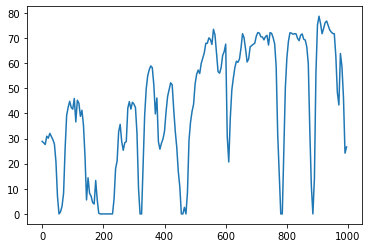

In [176]:

ax = plt.axes()
ax.plot(some_track['time_interval'],some_track['GPS Speed.value'])

## Getting the velocity equation

In [178]:
time_interval = np.array(some_track['time_interval'])
speed = np.array(some_track['GPS Speed.value'])
idx = np.isfinite(time_interval) & np.isfinite(speed)

def get_equation(x,y):
    degree = 80
    coefs, res, _, _, _ = np.polyfit(x,y,degree, full = True)
    ffit = np.poly1d(coefs)
    print (ffit)
    return ffit

speed_equation = get_equation(time_interval[idx], speed[idx])




            51             50             49              48
8.475e-141 x  - 2.52e-137 x  + 1.01e-134 x  + 1.944e-131 x 
               47             46              45              44
 + 4.262e-129 x  - 1.23e-125 x  - 1.599e-122 x  - 6.962e-120 x 
               43             42              41              40
 + 6.054e-117 x  + 1.39e-113 x  + 1.233e-110 x  + 3.372e-108 x 
               39              38             37             36
 - 7.064e-105 x  - 1.285e-101 x  - 1.102e-98 x  - 2.987e-96 x 
              35            34             33             32
 + 6.451e-93 x  + 1.19e-89 x  + 1.033e-86 x  + 2.727e-84 x 
              31             30             29             28
 - 6.337e-81 x  - 1.135e-77 x  - 9.116e-75 x  - 9.691e-73 x 
              27             26             25             24
 + 7.751e-69 x  + 1.092e-65 x  + 5.974e-63 x  - 3.586e-60 x 
              23             22             21             20
 - 1.017e-56 x  - 7.841e-54 x  + 1.802e-51 x  + 9.642e-48 x 
    

## Calculate the acceleration from the derivative of velocity equation

In [179]:
j = 0
for i in some_track.index:
    some_track.loc[i, 'Acceleration'] = derivative(speed_equation, some_track.loc[i, 'time_interval'])
    j = j+5
some_track

,id,time,geometry,GPS Speed.value,track.id,track.length,track.begin,track.end,sensor.fuelType,new,time_interval,Acceleration
0,5e8b930965b80c5d6b4d7cd1,2020-03-07T12:33:15,POINT (7.64069 51.95733),28.867655,5e8b930965b80c5d6b4d7ccf,11.969578,2020-03-07T12:33:15Z,2020-03-07T12:50:00Z,gasoline,2020-05-09 23:45:27,0.0,2.485211
1,5e8b930965b80c5d6b4d7cd3,2020-03-07T12:33:20,POINT (7.64118 51.95712),28.295928,5e8b930965b80c5d6b4d7ccf,11.969578,2020-03-07T12:33:15Z,2020-03-07T12:50:00Z,gasoline,2020-05-09 23:45:32,5.0,1.015863
2,5e8b930965b80c5d6b4d7cd4,2020-03-07T12:33:26,POINT (7.64162 51.95690),27.615373,5e8b930965b80c5d6b4d7ccf,11.969578,2020-03-07T12:33:15Z,2020-03-07T12:50:00Z,gasoline,2020-05-09 23:45:37,10.0,0.144695
3,5e8b930965b80c5d6b4d7cd5,2020-03-07T12:33:31,POINT (7.64210 51.95672),30.928370,5e8b930965b80c5d6b4d7ccf,11.969578,2020-03-07T12:33:15Z,2020-03-07T12:50:00Z,gasoline,2020-05-09 23:45:42,15.0,-0.352122
4,5e8b930965b80c5d6b4d7cd6,2020-03-07T12:33:36,POINT (7.64264 51.95650),30.144143,5e8b930965b80c5d6b4d7ccf,11.969578,2020-03-07T12:33:15Z,2020-03-07T12:50:00Z,gasoline,2020-05-09 23:45:47,20.0,-0.613246
...,...,...,...,...,...,...,...,...,...,...,...,...
195,5e8b930965b80c5d6b4d7d95,2020-03-07T12:49:40,POINT (7.78486 51.98988),63.831775,5e8b930965b80c5d6b4d7ccf,11.969578,2020-03-07T12:33:15Z,2020-03-07T12:50:00Z,gasoline,2020-05-10 00:01:50,975.0,0.653319
196,5e8b930965b80c5d6b4d7d96,2020-03-07T12:49:45,POINT (7.78551 51.98922),58.610634,5e8b930965b80c5d6b4d7ccf,11.969578,2020-03-07T12:33:15Z,2020-03-07T12:50:00Z,gasoline,2020-05-10 00:01:55,980.0,0.183598
197,5e8b930965b80c5d6b4d7d97,2020-03-07T12:49:50,POINT (7.78602 51.98866),46.312597,5e8b930965b80c5d6b4d7ccf,11.969578,2020-03-07T12:33:15Z,2020-03-07T12:50:00Z,gasoline,2020-05-10 00:02:00,985.0,-3.330274
198,5e8b930965b80c5d6b4d7d98,2020-03-07T12:49:55,POINT (7.78643 51.98834),24.179263,5e8b930965b80c5d6b4d7ccf,11.969578,2020-03-07T12:33:15Z,2020-03-07T12:50:00Z,gasoline,2020-05-10 00:02:05,990.0,-6.292816
